In [1]:
import pandas as pd

# Load dataset and GloVe word embedding from CSV file
data_path = '/content/drive/MyDrive/dataset/all-the-news-combined.csv'
glove_path = '/content/drive/MyDrive/glove/glove.6B.300d.txt'
data = pd.read_csv(data_path)
data.dropna(subset=['author', 'content'], inplace=True)  # Remove entries with missing author or content

<ipython-input-1-9dc082728e1b>:6: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [2]:
# Filter data to include only authors with a significant number (400 or more) of articles
author_counts = data['author'].value_counts()
frequent_authors = author_counts[author_counts >= 400].index

# List of grouped authors (not individuals) to be excluded from the analysis
authors_to_exclude = [
    "Associated Press",
    "Breitbart Jerusalem",
    "Breitbart London",
    "Breitbart News",
    "Editorial Board",
    "Fox News",
    "NPR Staff",
    "Post Editorial Board",
    "Post Staff Report",
    "Reuters",
    "The Editors"
]

# Filter out the authors in the exclusion list
data = data[data['author'].isin(frequent_authors) & ~data['author'].isin(authors_to_exclude)]

# Display the names of qualified authors
qualified_authors = data['author'].unique()
print("Qualified Authors:")
for author in qualified_authors:
    print(author)

Qualified Authors:
Camila Domonoske
Merrit Kennedy
Bill Chappell
Ian Hanchett
Katherine Rodriguez
Jerome Hudson
Charlie Spiering
AWR Hawkins
Warner Todd Huston
Jeff Poor
Trent Baker
Daniel Nussbaum
John Hayward
Pam Key
Joel B. Pollak
Charlie Nash
Alex Swoyer


In [3]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')  # Download the Punkt tokenizer models

# Tokenize the content of each article into sentences using NLTK's sent_tokenize
data['sentences'] = data['content'].apply(sent_tokenize)

# Explode the DataFrame to separate each sentence into its own row, while keeping the associated author the same
# This operation transforms each list of sentences into separate rows, duplicating the other column values as needed.
data = data.explode('sentences').reset_index(drop=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')

# Function to preprocess text by removing digits, punctuation, and stop words, and applying lemmatization
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    return ' '.join(lemmatizer.lemmatize(word) for word in words if word not in stop_words)

# Apply preprocessing to the content of each article
data['processed_content'] = data['sentences'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import numpy as np

# Function to load GloVe embeddings from file
def load_glove_embeddings(path):
    embeddings_index = {}
    dimension = None
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            if dimension is None:
                dimension = len(values) - 1  # Set the dimensionality of the vectors
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index, dimension

# Load GloVe embeddings
glove_embeddings, embedding_dim = load_glove_embeddings(glove_path)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize and fit tokenizer on the processed content
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['processed_content'])
sequences = tokenizer.texts_to_sequences(data['processed_content'])

# Determine the optimal length of sequences for padding
sequence_lengths = [len(seq) for seq in sequences]
maxlen = int(np.percentile(sequence_lengths, 95))  # Using the 95th percentile to determine maxlen

# Pad sequences to ensure consistent length
X = pad_sequences(sequences, maxlen=maxlen)

# Prepare the embedding matrix by mapping GloVe vectors to the corresponding words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode author names into categorical labels
encoder = LabelEncoder()
y = encoder.fit_transform(data['author'])

# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, GRU, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Define the LSTM model architecture
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True),
    SpatialDropout1D(0.2),
    LSTM(128, return_sequences=True, dropout=0.2),
    Dropout(0.25),
    LSTM(128, return_sequences=True, dropout=0.2),
    Dropout(0.25),
    LSTM(64, dropout=0.2),
    Dropout(0.2),
    Dense(len(set(y)), activation='softmax')
])

# Compile the LSTM model with defined optimizer and loss function
optimizer = RMSprop(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to halt training when validation loss ceases to decrease
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Train the LSTM model with early stopping
history_lstm = model_lstm.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the LSTM model on the test data
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss_lstm}, Test Accuracy: {test_acc_lstm}")

# Predict labels for the test set and generate a classification report
y_pred_lstm = model_lstm.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1) # Convert probabilities to class labels
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_classes_lstm, target_names=encoder.classes_))

Epoch 1/30
2155/2155 [==============================] - 50s 20ms/step - loss: 2.2573 - accuracy: 0.2827 - val_loss: 2.0755 - val_accuracy: 0.3346
Epoch 2/30
2155/2155 [==============================] - 22s 10ms/step - loss: 2.0156 - accuracy: 0.3571 - val_loss: 1.9401 - val_accuracy: 0.3750
Epoch 3/30
2155/2155 [==============================] - 22s 10ms/step - loss: 1.9003 - accuracy: 0.3938 - val_loss: 1.8614 - val_accuracy: 0.4011
Epoch 4/30
2155/2155 [==============================] - 21s 10ms/step - loss: 1.8215 - accuracy: 0.4195 - val_loss: 1.8234 - val_accuracy: 0.4154
Epoch 5/30
2155/2155 [==============================] - 21s 10ms/step - loss: 1.7600 - accuracy: 0.4407 - val_loss: 1.8014 - val_accuracy: 0.4245
Epoch 6/30
2155/2155 [==============================] - 21s 10ms/step - loss: 1.7062 - accuracy: 0.4582 - val_loss: 1.7749 - val_accuracy: 0.4381
Epoch 7/30
2155/2155 [==============================] - 20s 9ms/step - loss: 1.6577 - accuracy: 0.4741 - val_loss: 1.7767 - 

In [8]:
# Define the GRU model architecture
model_gru = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True),
    SpatialDropout1D(0.2),
    GRU(128, return_sequences=True, dropout=0.2),
    GRU(128, return_sequences=True, dropout=0.2),
    GRU(64, dropout=0.2),
    Dropout(0.2),
    Dense(len(set(y)), activation='softmax')
])

# Compile the GRU model with defined optimizer and loss function
optimizer = RMSprop(learning_rate=0.001)
model_gru.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to halt training when validation loss ceases to decrease
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Train the GRU model with early stopping
history_gru = model_gru.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the GRU model on the test data
test_loss_gru, test_acc_gru = model_gru.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss_gru}, Test Accuracy: {test_acc_gru}")

# Predict labels for the test set and generate a classification report
y_pred_gru = model_gru.predict(X_test)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1) # Convert probabilities to class labels
print("GRU Classification Report:")
print(classification_report(y_test, y_pred_classes_gru, target_names=encoder.classes_))

Epoch 1/30
2155/2155 [==============================] - 38s 16ms/step - loss: 2.2183 - accuracy: 0.2969 - val_loss: 1.9950 - val_accuracy: 0.3578
Epoch 2/30
2155/2155 [==============================] - 21s 10ms/step - loss: 1.9660 - accuracy: 0.3752 - val_loss: 1.8903 - val_accuracy: 0.3989
Epoch 3/30
2155/2155 [==============================] - 20s 9ms/step - loss: 1.8553 - accuracy: 0.4107 - val_loss: 1.8293 - val_accuracy: 0.4158
Epoch 4/30
2155/2155 [==============================] - 20s 9ms/step - loss: 1.7779 - accuracy: 0.4359 - val_loss: 1.7832 - val_accuracy: 0.4349
Epoch 5/30
2155/2155 [==============================] - 20s 9ms/step - loss: 1.7112 - accuracy: 0.4589 - val_loss: 1.7663 - val_accuracy: 0.4423
Epoch 6/30
2155/2155 [==============================] - 20s 9ms/step - loss: 1.6582 - accuracy: 0.4749 - val_loss: 1.7493 - val_accuracy: 0.4483
Epoch 7/30
2155/2155 [==============================] - 20s 9ms/step - loss: 1.6087 - accuracy: 0.4919 - val_loss: 1.7425 - val_

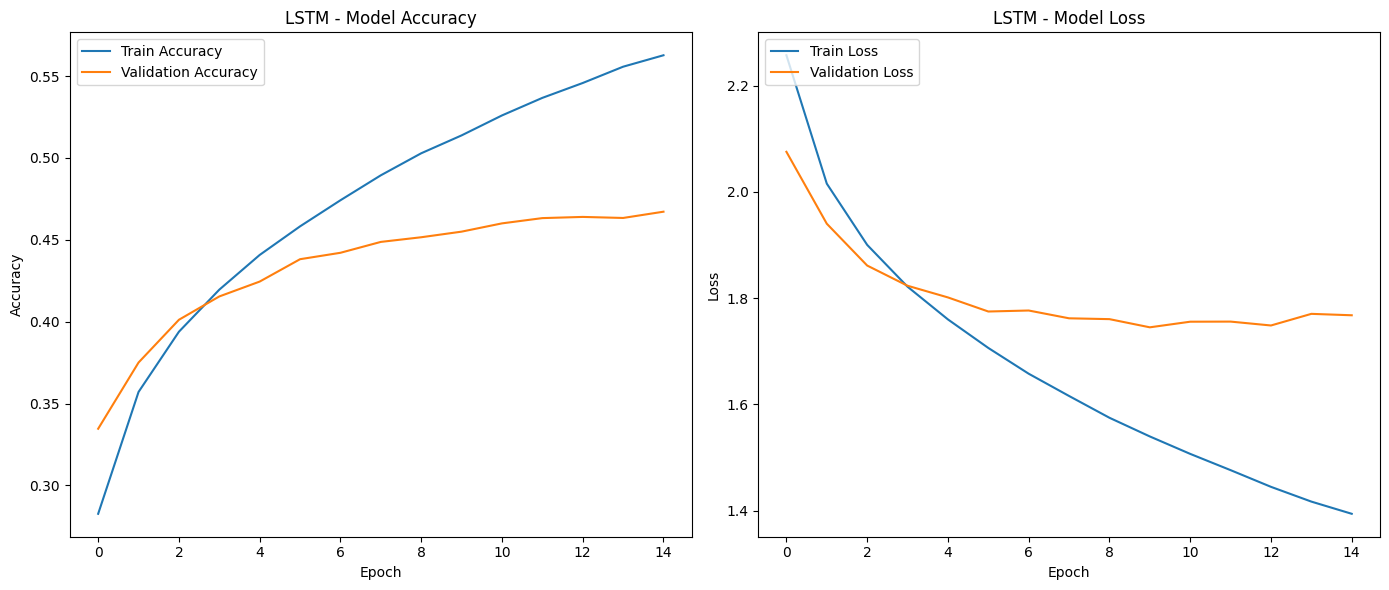

LSTM Model Evaluation
Accuracy: 0.46
Macro Precision: 0.52
Macro Recall: 0.42
Macro F1 Score: 0.44


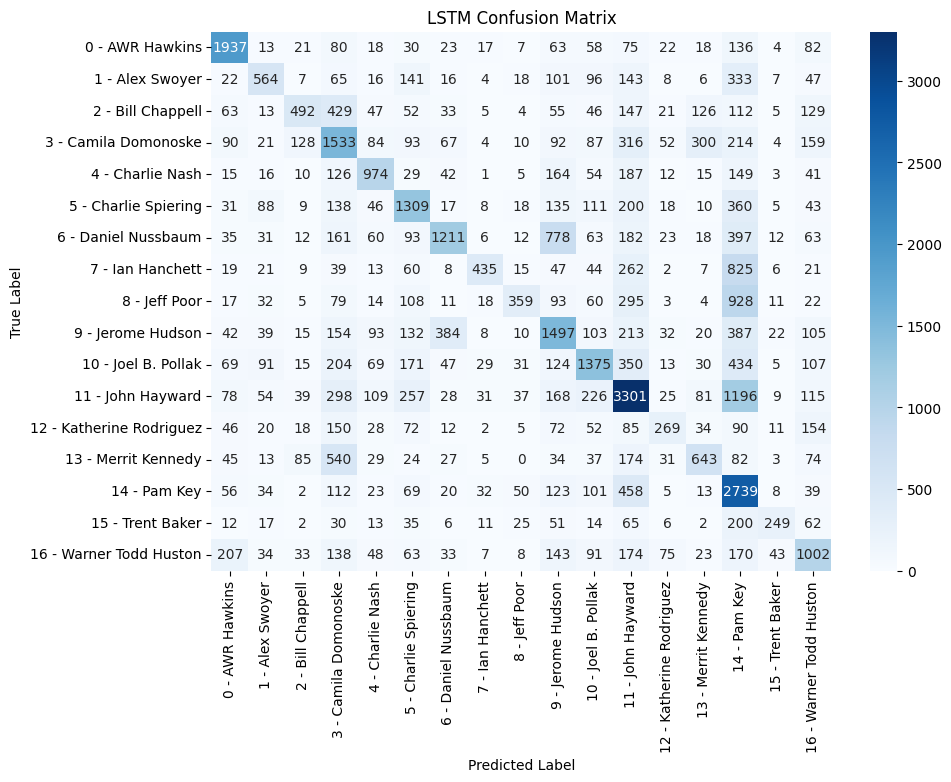

Confusion Matrix Breakdown for LSTM:
Author 0 - TP: 1937, FP: 847, FN: 667, TN: 39632
Author 1 - TP: 564, FP: 537, FN: 1030, TN: 40952
Author 2 - TP: 492, FP: 410, FN: 1287, TN: 40894
Author 3 - TP: 1533, FP: 2743, FN: 1721, TN: 37086
Author 4 - TP: 974, FP: 710, FN: 869, TN: 40530
Author 5 - TP: 1309, FP: 1429, FN: 1237, TN: 39108
Author 6 - TP: 1211, FP: 774, FN: 1946, TN: 39152
Author 7 - TP: 435, FP: 188, FN: 1398, TN: 41062
Author 8 - TP: 359, FP: 255, FN: 1700, TN: 40769
Author 9 - TP: 1497, FP: 2243, FN: 1759, TN: 37584
Author 10 - TP: 1375, FP: 1243, FN: 1789, TN: 38676
Author 11 - TP: 3301, FP: 3326, FN: 2751, TN: 33705
Author 12 - TP: 269, FP: 348, FN: 851, TN: 41615
Author 13 - TP: 643, FP: 707, FN: 1203, TN: 40530
Author 14 - TP: 2739, FP: 6013, FN: 1145, TN: 33186
Author 15 - TP: 249, FP: 158, FN: 551, TN: 42125
Author 16 - TP: 1002, FP: 1263, FN: 1290, TN: 39528


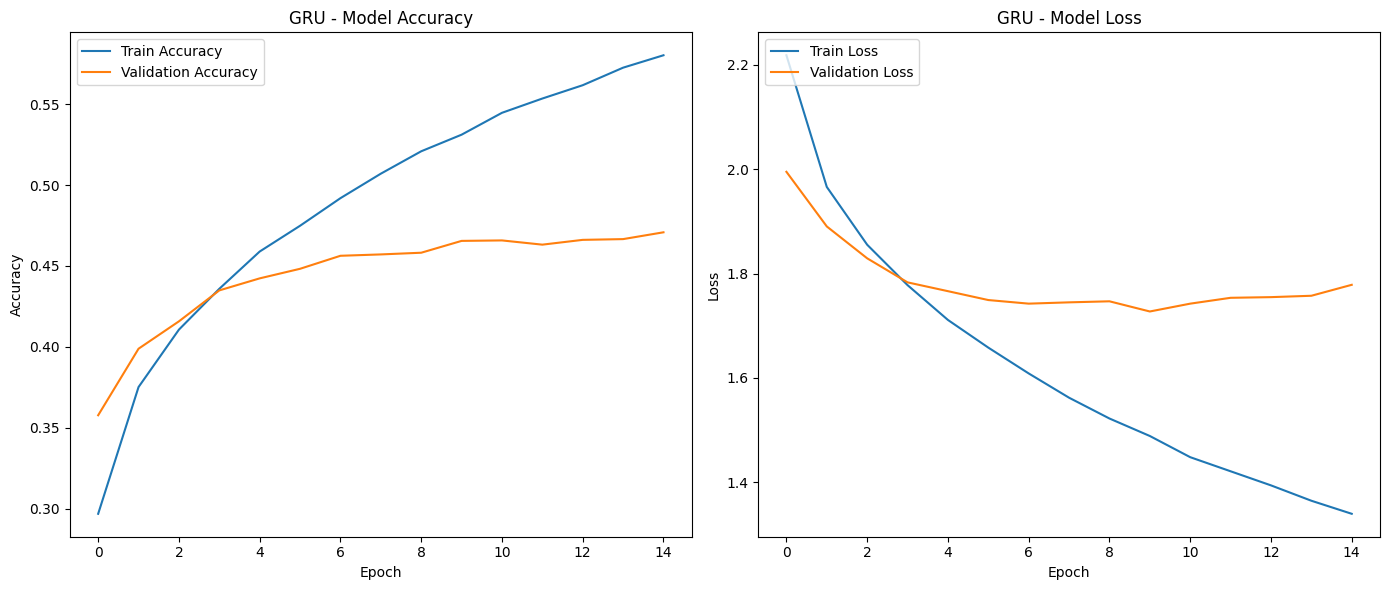

GRU Model Evaluation
Accuracy: 0.47
Macro Precision: 0.51
Macro Recall: 0.43
Macro F1 Score: 0.45


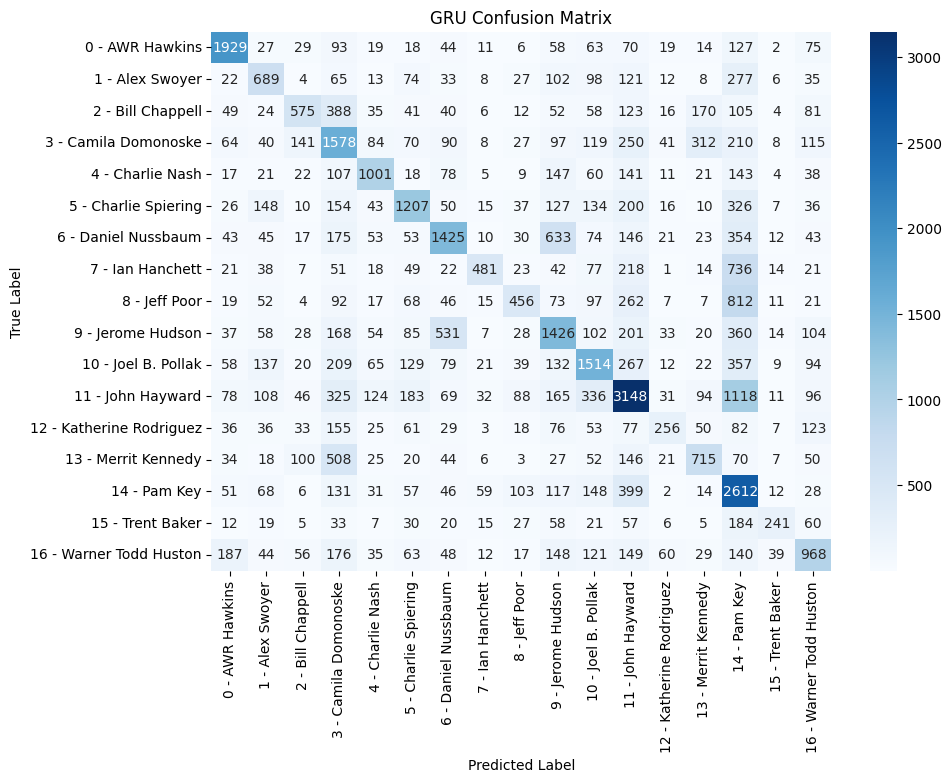

Confusion Matrix Breakdown for GRU:
Author 0 - TP: 1929, FP: 754, FN: 675, TN: 39725
Author 1 - TP: 689, FP: 883, FN: 905, TN: 40606
Author 2 - TP: 575, FP: 528, FN: 1204, TN: 40776
Author 3 - TP: 1578, FP: 2830, FN: 1676, TN: 36999
Author 4 - TP: 1001, FP: 648, FN: 842, TN: 40592
Author 5 - TP: 1207, FP: 1019, FN: 1339, TN: 39518
Author 6 - TP: 1425, FP: 1269, FN: 1732, TN: 38657
Author 7 - TP: 481, FP: 233, FN: 1352, TN: 41017
Author 8 - TP: 456, FP: 494, FN: 1603, TN: 40530
Author 9 - TP: 1426, FP: 2054, FN: 1830, TN: 37773
Author 10 - TP: 1514, FP: 1613, FN: 1650, TN: 38306
Author 11 - TP: 3148, FP: 2827, FN: 2904, TN: 34204
Author 12 - TP: 256, FP: 309, FN: 864, TN: 41654
Author 13 - TP: 715, FP: 813, FN: 1131, TN: 40424
Author 14 - TP: 2612, FP: 5401, FN: 1272, TN: 33798
Author 15 - TP: 241, FP: 167, FN: 559, TN: 42116
Author 16 - TP: 968, FP: 1020, FN: 1324, TN: 39771


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Function to plot training history for accuracy and loss
def plot_history(history, title):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + ' - Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title + ' - Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    labels = [f'{i} - {class_name}' for i, class_name in enumerate(classes)]

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return cm

# Function to evaluate model performance
def evaluate_model(name, y_true, y_pred, classes, history):
    plot_history(history, name)  # Plot the training and validation history
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{name} Model Evaluation")
    print("Accuracy: {:.2f}".format(accuracy))
    print("Macro Precision: {:.2f}".format(precision))
    print("Macro Recall: {:.2f}".format(recall))
    print("Macro F1 Score: {:.2f}".format(f1))

    cm = plot_confusion_matrix(y_true, y_pred, classes, name)  # Plot the confusion matrix

    # Detailed breakdown of the confusion matrix
    print(f"Confusion Matrix Breakdown for {name}:")
    for i in range(len(classes)):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        print(f"Author {i} - TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

# Evaluating LSTM model
evaluate_model("LSTM", y_test, y_pred_classes_lstm, encoder.classes_, history_lstm)

# Evaluating GRU model
evaluate_model("GRU", y_test, y_pred_classes_gru, encoder.classes_, history_gru)

In [10]:
# Save the LSTM and GRU models to the specified directory
model_lstm.save('/content/model_lstm.h5')  # saves the model in HDF5 format
model_gru.save('/content/model_gru.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import pickle

# Save the tokenizer
with open('/content/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the LabelEncoder
with open('/content/encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
import zipfile

# Create a zip file containing the models and other necessary files
with zipfile.ZipFile('/content/model_files.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('/content/model_lstm.h5', arcname='model_lstm.h5')
    zipf.write('/content/model_gru.h5', arcname='model_gru.h5')
    zipf.write('/content/tokenizer.pickle', arcname='tokenizer.pickle')
    zipf.write('/content/encoder.pickle', arcname='encoder.pickle')